In [51]:

# Import Modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import re
import sys
import config
import importlib
import itertools
from sklearn.linear_model import HuberRegressor

sys.path.insert(1, '/Users/yifu/PycharmProjects/Radiotherapy-Prediction')
import utils.VarReader as VarReader

In [52]:
# Data Paths
data_dir = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/"
plot_dir = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2" 
# Ensure both directories exist
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
raw_data_path = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/output/2022-07-15-102348_without_imputation_fixed/DataFrames/Dataset-expert-imputed.csv"
out_data_path = os.path.join(data_dir, "RadiationAndANN_DATA_2021-11-15_0835_data_exploration.csv")
dictionary_path = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/input/metadata/Metadata.xlsx"

In [53]:
# Columns to be cross-tabulated
cross_tab_cols_set1 = ["PRE_susp_LN_prsnt_composite", "PRE_susp_LN_max_size_composite", "PRE_tumor_max_size_composite", "PRE_height_cm", "PRE_weight_kg"]
# cross_tab_cols_set1 = ["PRE_height_cm", "PRE_weight_kg"]
cross_tab_cols_set2 = ['lymphovascular_invasion', 'metastasis', 'ln_w_micrometastasis', 'ln_w_macrometastasis', 'number_of_positive_sln', 'size_of_largest_nodal_meta', 'extranodal_extension', 'extent_of_extranodal_exten', 'mar_status',  'dis_closest_margin', 'tu_grade', 'tumor_size', 'tumor_focality', 'num_foci', 'did_the_patient_receive_pm']

# Global Variables 
susp_LN_present_composite_cols = [
        'abnormal_lymph',  # Ultrasound
        'prominent_axillary_lymph',  # Mammography
        'axillary_lymphadenopathy',  # MRI
        'internal_mammary_lymphaden',  # MRI
        'axillary_lymphadenopathy_p',
        'int_mammary_lymphade_pet',
        'axillary_lymph_node_palpab'
        ]
susp_LN_present_composite_cols = ["PRE_" + col for col in susp_LN_present_composite_cols]

susp_LN_max_size_composite_cols = [
    'lymph_node_max_size_mm',
    'lymph_node_max_size_mm0',
    'axillary_lymph_node_max_si',
    'internal_mammary_lymph_nod'
    ]
susp_LN_max_size_composite_cols = ["PRE_" + col for col in susp_LN_max_size_composite_cols]

pre_tumor_max_size_composite_cols = [
        "img_size",  # Ultrasound, in MM
        "tumor_size_mm",  # Mammography, in MM
        "size_of_the_largest_foci_c",  # PET, in CM
]
pre_tumor_max_size_composite_cols = ["PRE_" + col for col in pre_tumor_max_size_composite_cols]

pre_composite_col_names = [
        "PRE_susp_LN_prsnt_composite",
        "PRE_susp_LN_size_composite",
        "PRE_tumor_max_size_composite"
]
pre_sections = ['Demographics', 'Ultrasound report', 'Diagnostic mammogram report', 'MRI report', 'PET scan', 'Pre-operative Biopsy Report', 'Pre-Composite']
pos_sections = ['Intra-operative Findings', 'Post-operative Surgical Pathology Report']
pre_sections_abbr = [x[:3].upper() for x in pre_sections]
pos_sections_abbr = [x[:3].upper() for x in pos_sections]

In [54]:
susp_LN_present_composite_cols

['PRE_abnormal_lymph',
 'PRE_prominent_axillary_lymph',
 'PRE_axillary_lymphadenopathy',
 'PRE_internal_mammary_lymphaden',
 'PRE_axillary_lymphadenopathy_p',
 'PRE_int_mammary_lymphade_pet',
 'PRE_axillary_lymph_node_palpab']

In [55]:
# Load Data
df = pd.read_csv(raw_data_path)
df.loc[df["POS_metastasis"] == 3, "POS_metastasis"] = np.nan
df.loc[df["POS_metastasis"] == 2, "POS_metastasis"] = 0
df.head()

,PRE_record_id,PRE_dob,PRE_age_at_dx,PRE_age_at_surg,PRE_men_status,PRE_fmhx,PRE_gensus___brca1,PRE_gensus___brca2,PRE_gensus___p53,PRE_gensus___pten,...,POS_dis_closest_margin,POS_metastasis,POS_ln_w_micrometastasis,POS_ln_w_macrometastasis,POS_size_of_largest_nodal_meta,POS_extranodal_extension,POS_extent_of_extranodal_exten,POS_did_the_patient_receive_pm,POS_did_the_patient_reject_pmr,POS_data_collection_fields_complete
0,292.0,1966,51.0,51.0,0.0,0.0,0,0,0,0,...,0.25,0.0,NaN,NaN,NaN,2.0,NaN,1.0,0.0,2
1,491.0,1948,66.0,66.0,2.0,0.0,0,0,0,0,...,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,0.0,2
2,296.0,1959,58.0,59.0,2.0,1.0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2
3,42.0,1957,62.0,62.0,2.0,0.0,0,0,0,0,...,4.00,1.0,0.0,4.0,12.0,1.0,1.5,1.0,NaN,2
4,486.0,1955,59.0,59.0,2.0,1.0,0,0,0,0,...,5.50,0.0,NaN,NaN,NaN,2.0,NaN,0.0,0.0,2


In [56]:
# Load Data Dictionary
dictionary = pd.read_excel(dictionary_path)
# # Rename "Variable / Field Name" to "Variable" column
# dictionary.rename(columns={'Variable / Field Name': 'Variable'}, inplace=True)
# # Rename "Choices, Calculations, OR Slider Labels" to "Options"
# dictionary.rename(columns={'Choices, Calculations, OR Slider Labels': 'Options'}, inplace=True)
# # Rename "Field Type" to "Type" 
# dictionary.rename(columns={'Field Type': 'Type'}, inplace=True)
# # Rename "Field Label" to "Label"
# dictionary.rename(columns={'Field Label': 'Label'}, inplace=True)
# For the column "Section Header", replace NaN with the previous non-NaN value
# dictionary["Section Header"].fillna(method='ffill', inplace=True)
# Rename "Section Header" to "Section"
# dictionary.rename(columns={'Section Header': 'Section'}, inplace=True)
# Add the composite columns to dictionary
susp_LN_present_composite_row = {
    "Field": "PRE_susp_LN_prsnt_composite",
    "Options": "0, absent | 1, present",
    "Type": "yesno",
    "Label": "Abnormal LN or lymphadenopathy, PRE",
    # "Section": "Pre-Composite"
}
susp_LN_max_size_composite_row = {
    "Field": "PRE_susp_LN_max_size_composite",
    "Type": "text",
    "Label": "Largest LN size, PRE",
    # "Section": "Pre-Composite"
}
pre_tumor_max_size_composite_row = {
    "Variable": "PRE_tumor_max_size_composite",
    "Type": "text",
    "Label": "Largest tumor size, PRE",
    # "Section": "Pre-Composite"
}
# Ensure all numeric columns are numeric
# Ensure all values are numeric, if not, replace with NaN
for i, row in dictionary.iterrows():
    col_name = row["Field"]
    if (col_name in cross_tab_cols_set1 or col_name in cross_tab_cols_set2) and row["Type"] == "text":
        new_data = [float(x) if isinstance(x, (int, float)) or (x.replace(".","",1).isnumeric()) else np.nan for x in df[col_name]]
        # For each nan, print the original value
        skipped_data = [df.iloc[i][col_name] for i, x in enumerate(new_data) if np.isnan(x)]
        if len(skipped_data):
            print(f"{col_name} has {len(skipped_data)} invalid values: {skipped_data}")
        df[col_name] = new_data

susp_LN_present_composite_row = pd.DataFrame(susp_LN_present_composite_row, index=[len(dictionary)])
susp_LN_max_size_composite_row = pd.DataFrame(susp_LN_max_size_composite_row, index=[len(dictionary)+ 1])
pre_tumor_max_size_composite_row = pd.DataFrame(pre_tumor_max_size_composite_row, index=[len(dictionary) + 2])
dictionary = pd.concat([dictionary, susp_LN_present_composite_row, susp_LN_max_size_composite_row, pre_tumor_max_size_composite_row])
cross_tab_cols_set2 = ["POS_" + col for col in cross_tab_cols_set2]
cross_tab_cols_set2.append('PRE_metastatic_carcinoma_on_ax')

dictionary

,Field,Group,Missingness,Cleansing_Script,Imputation_Script_if_Missing,Type,Values,Description,Original Options,Original Field Name,Options,Label,Variable
0,PRE_men_status,PRE,0.002,"if val == 3: \n val = """"","if row[""PRE_age_at_dx""] > 50:\n val = 2\nelse...",categorical,"0, pre-menopausal | 1, peri-menopausal | 2, po...",Menopausal status,NaN,men_status,NaN,NaN,NaN
1,PRE_axillary_lymph_node_palpab,PRE,0.042,NaN,val = 0,categorical,NaN,Axillary lymph node palpability,NaN,axillary_lymph_node_palpab,NaN,NaN,NaN
2,PRE_er_status,PRE,0.062,if val == 3:\n val = 1.5,val = 1.5,ordinal,"1, positive | 2, negative | 1.5, equivocal",Estrogen receptor status,NaN,er_status,NaN,NaN,NaN
3,PRE_tumor_grade,PRE,0.065,"if val == 4 or val == 0:\n val = """"","if row[""PRE_lymphovascular_invasion0""] == 1:\n...",ordinal,"1, 1 | 2, 2 | 3, 3 | 4, 0= N/A",Tumor grade,NaN,tumor_grade,NaN,NaN,NaN
4,PRE_pr_status,PRE,0.153,if val == 3:\n val = 1.5,val = 1.5,ordinal,"1, positive | 2, negative | 1.5, equivocal",Progesterone receptor status,NaN,pr_status,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,PRE_sln_met_RF_prob_binary,PRE,NaN,NaN,NaN,categorical,"1, present | 0, absent",prediction of SLN metastasis from Random Forest,NaN,NaN,NaN,NaN,NaN
140,PRE_sln_met_RF_prob,PRE,NaN,NaN,NaN,real,NaN,probability of SLN metastasis from Random Forest,NaN,NaN,NaN,NaN,NaN
141,PRE_susp_LN_prsnt_composite,NaN,NaN,NaN,NaN,yesno,NaN,NaN,NaN,NaN,"0, absent | 1, present","Abnormal LN or lymphadenopathy, PRE",NaN
142,PRE_susp_LN_max_size_composite,NaN,NaN,NaN,NaN,text,NaN,NaN,NaN,NaN,NaN,"Largest LN size, PRE",NaN


In [57]:
config.dictionary_path = dictionary_path = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/input/metadata/Metadata.xlsx"
importlib.reload(VarReader)
VarReader = VarReader.VarReader()


In [58]:
def read_col_attributes(col_name, has_missing):
    temp = VarReader.read_var_attrib(col_name, has_missing)
    return temp["section"], temp["dtype"], temp["label"], temp["options"], temp["options_str"]

In [59]:
from collections import OrderedDict
from matplotlib.colors import ListedColormap

# def read_col_attributes(col_name, has_missing):
#     try:
#         definition = dictionary[dictionary["Field"] == col_name]
#         section = definition["Group"].iloc[0]
#         if str(section) == "nan":
#             section = "Other"
#             print(f"{col_name} is not in the dictionary")
#         section = section.upper()[:3]
#         dtype = definition["Type"].iloc[0]  # radio, checkbox, text, yesno
#         label = definition["Description"].iloc[0]
#         options = definition["Values"].iloc[0]
#         # Replace special characters and symbols in section and label using regex
#         section = re.sub(r'[^\w]', ' ', section)
#         # label = re.sub(r'[^\w]', ' ', label)
#         # Options have format {tick_value: label, ...}
#         if str(options) != "nan":
#                 options = {int(x.split(",")[0].strip()) : x.split(",")[1].strip() for x in options.split("|")}
#                 if has_missing:
#                     options[-1] = "missing"
#                 options = OrderedDict(sorted(options.items()))
#         else:
#             options = {}
#         options_str = " | ".join([str(x) + ", " + str(y) for x, y in options.items()])
#         return section, dtype, label, options, options_str
#     except Exception as e:
#         print(f"Error reading attributes for {col_name}")
#         print(e)
#         return None

def append_prefix_to_col_name(col_name):
    section, dtype, label, options, options_str = read_col_attributes(col_name)
    if section in pre_sections_abbr:
        if not col_name.lower().startswith("pre_"):
            prefix = "PRE_"
        else:
            prefix = ""
    elif section in pos_sections_abbr:
        prefix = "POS_"
    else:
        print(f"Cannot find the appropriate prefix/section of {col_name}, please check column name and dictionary.")
        prefix = ""
    return prefix + col_name


def is_dtype_categorical(dtype):
    return dtype in ["radio", "checkbox", "yesno", "categorical", "ordinal"]

In [60]:
# For each column in df, append prefix to column name
# for col_name in df.columns:
#     new_col_name = append_prefix_to_col_name(col_name)
#     df.rename(columns={col_name: new_col_name}, inplace=True)

# For each variable in dictionary, append prefix to column name
# for i, row in dictionary.iterrows():
#     col_name = row["Field"]
#     new_col_name = append_prefix_to_col_name(col_name)
#     dictionary.loc[i, "Field"] = new_col_name

In [61]:
### Construct composite columns and insert to dataframe ###

pd.set_option('display.expand_frame_repr', False)


# def is_float(x):
#     try:
#         float(x)
#         return True
#     except ValueError:
#         return False

# # Construct composite features for PRE Lymph Node Abnormality Presence
# # Replace 3 (not mentioned) and 2 (No) with 0 (negative) for the pre_susp_LN_prsnt_composite columns
# for col in list(itertools.chain(
#     susp_LN_present_composite_cols, susp_LN_max_size_composite_cols, pre_tumor_max_size_composite_cols)
#     ):
#     if col in susp_LN_present_composite_cols:
#         df[col] = df[col].replace(3, 0).replace(2, 0)
#     # make sure the column is numeric, replace all values that are not numeric with -1
#     df[col] = df[col].apply(lambda x: -1 if not is_float(x) else x)
#     # Caste the column into float
#     df[col] = df[col].astype(float)

# susp_LN_present_composite = df[susp_LN_present_composite_cols].max(axis=1, numeric_only=True)
# # Add the composite feature to the dataframe, insert at the first position of source cols
# idx = df.columns.get_loc(susp_LN_present_composite_cols[0])
# # Insert if it doesn't exist
# if "PRE_susp_LN_prsnt_composite" not in df.columns:
#     df.insert(idx, "PRE_susp_LN_prsnt_composite", susp_LN_present_composite)
# print(df[["PRE_susp_LN_prsnt_composite"] + susp_LN_present_composite_cols])

# susp_LN_max_size_composite = df[susp_LN_max_size_composite_cols].max(axis=1, numeric_only=True)
# # Add the composite feature to the dataframe, insert at the first position of source cols
# idx = df.columns.get_loc(susp_LN_max_size_composite_cols[0])
# # Insert if it doesn't exist
# if "PRE_susp_LN_max_size_composite" not in df.columns:
#     df.insert(idx, "PRE_susp_LN_max_size_composite", susp_LN_max_size_composite)
# print(df[["PRE_susp_LN_max_size_composite"] + susp_LN_max_size_composite_cols])

# pre_tumor_max_size_composite = df[pre_tumor_max_size_composite_cols].max(axis=1, numeric_only=True)
# # Add the composite feature to the dataframe, insert at the first position of source cols
# idx = df.columns.get_loc(pre_tumor_max_size_composite_cols[0])
# # Insert if it doesn't exist
# if "PRE_tumor_max_size_composite" not in df.columns:
#     df.insert(idx, "PRE_tumor_max_size_composite", pre_tumor_max_size_composite)
# print(df[["PRE_tumor_max_size_composite"] + pre_tumor_max_size_composite_cols])

In [62]:
# A Helper function to save the plot to a file
def save_plot(plot_name, plot_missing=False):
    # Replace non-word characters in the plot name with underlines
    plot_name = re.sub(r'[^\w]', '_', plot_name)
    plot_name = plot_name + "_incl_missing" if plot_missing else plot_name
    plot_path = os.path.join(plot_dir, plot_name + ".png")
    # Make plot background white
    # Show the plot and save
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    # Increase the plot size for saving
    plt.gcf().set_size_inches(20, 10)
    # Save plot in ultra-high-resolution
    plt.savefig(plot_path, bbox_inches='tight', facecolor='white', dpi=300)
    print("Saved plot to: {}".format(plot_path))
    # Set the plot size back to normal
    plt.gcf().set_size_inches(10, 5)
    
def save_plot_cols(col1, col2, plot_type, plot_missing):
    global cross_tab_cols_set1, cross_tab_cols_set2
    if col1 in cross_tab_cols_set2 and col2 in cross_tab_cols_set1:
        col1, col2 = col2, col1
    plot_name = f"{col1}-VS-{col2}__{plot_type}"
    save_plot(plot_name, plot_missing)
    

Value counts for pre_susp_LN_prsnt_composite:
0    612
1    188
Name: PRE_susp_LN_prsnt_composite, dtype: int64


<AxesSubplot:xlabel='PRE_susp_LN_prsnt_composite', ylabel='count'>

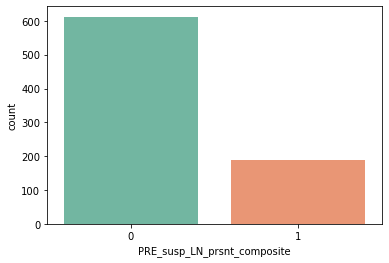

In [63]:

section, dtype, label, options, options_str = read_col_attributes("PRE_susp_LN_prsnt_composite",df.PRE_susp_LN_prsnt_composite.isnull().any())
# Check results
print("Value counts for pre_susp_LN_prsnt_composite:")
print(df["PRE_susp_LN_prsnt_composite"].value_counts())
# Make the x-tick label correspond to option label
x_tick_labels = [f"{k} ({v})" for k, v in options.items()]
# Plot the distribution of the pre_susp_LN_prsnt_composite
sns.countplot(x="PRE_susp_LN_prsnt_composite", data=df, palette="Set2")

Value counts for pre_susp_LN_max_size_composite:
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_susp_LN_max_size_composite.png


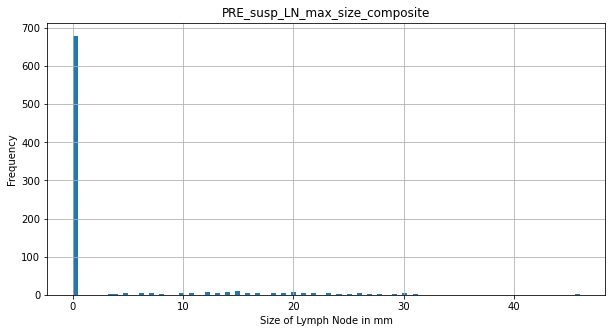

In [64]:
# Check results - Plot the column with sorted values 
print("Value counts for pre_susp_LN_max_size_composite:")
df["PRE_susp_LN_size_composite"].hist(bins=100)
# Mark the axis and median value 
# plt.axvline(susp_LN_max_size_composite.median(), color="r", linestyle="--")
plt.title("PRE_susp_LN_max_size_composite")
plt.xlabel(f"Size of Lymph Node in mm")
plt.ylabel("Frequency")
save_plot("PRE_susp_LN_max_size_composite")
# plt.show()

Value counts for pre_tumor_max_size_composite:
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_tumor_max_size_composite.png


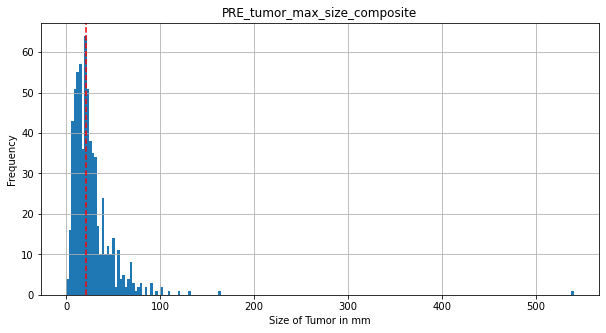

In [65]:
# Check results - Plot the column with sorted values 
print("Value counts for pre_tumor_max_size_composite:")
# Make a histogram of the column, with bins of 50
df["PRE_tumor_max_size_composite"].hist(bins=200)
# Mark the axis and median value
plt.axvline(df["PRE_tumor_max_size_composite"].median(), color="r", linestyle="--")
plt.title("PRE_tumor_max_size_composite")
plt.xlabel("Size of Tumor in mm")
plt.ylabel("Frequency")
save_plot("PRE_tumor_max_size_composite")

In [66]:
# Save the dataframe to a csv file
out_csv_path = os.path.join(data_dir, "data_with_composite.csv")
# Replace all instances of -1 with NaN
df_save = df.replace(-1, np.nan)
df_save.to_csv(out_csv_path, index=False)
print("Saved dataframe to: {}".format(out_csv_path))

Saved dataframe to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/data_with_composite.csv


In [67]:
df.fillna(-1, inplace=True)

def has_missing(df, col_name):
    # Return true if any value is -1
    has_neg1 = df[col_name].isin([-1]).any()
    return has_neg1

--------------------------------------------------
section1, dtype1, label1, options1, options_str1 PRE categorical Surgical Indication (Recurrent cancer) OrderedDict([(0.0, 'No'), (1.0, 'Yes')]) 0.0, No | 1.0, Yes
PRE_surg_indicat_prim___recurrent_cancer (categorical, PRE) vs POS_metastasis (categorical, POS)
y_label
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_surg_indicat_prim___recurrent_cancer_VS_POS_metastasis__cross_tab.png


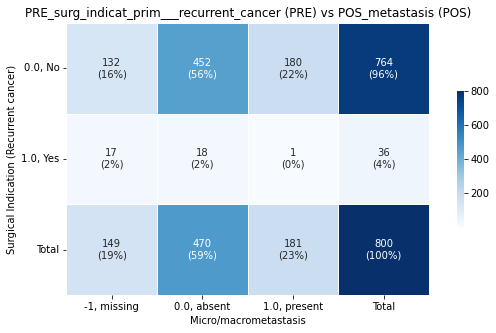

PRE_surg_indicat_prim___recurrent_cancer (categorical, PRE) vs POS_did_the_patient_receive_pm (categorical, POS)
y_label
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_surg_indicat_prim___recurrent_cancer_VS_POS_did_the_patient_receive_pm__cross_tab.png


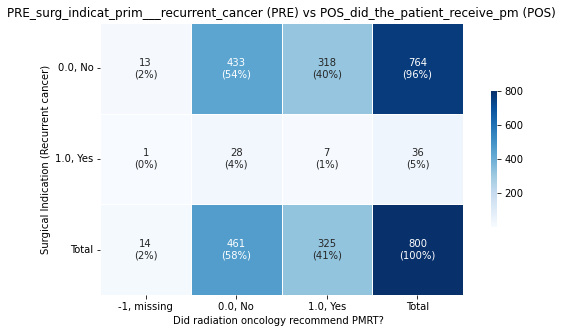

PRE_surg_indicat_prim___recurrent_cancer (categorical, PRE) vs POS_tumor_size (real, POS)
y_label
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_surg_indicat_prim___recurrent_cancer_VS_POS_tumor_size__boxplot.png


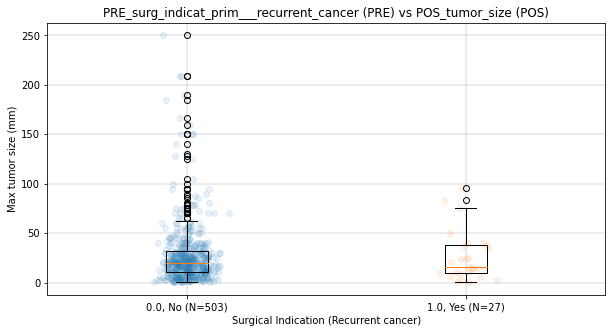

--------------------------------------------------
section1, dtype1, label1, options1, options_str1 PRE time First Diagnostic Imaging date {} 
PRE_dximg_date (time, PRE) vs POS_metastasis (categorical, POS)
y_label
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_dximg_date_VS_POS_metastasis__boxplot.png


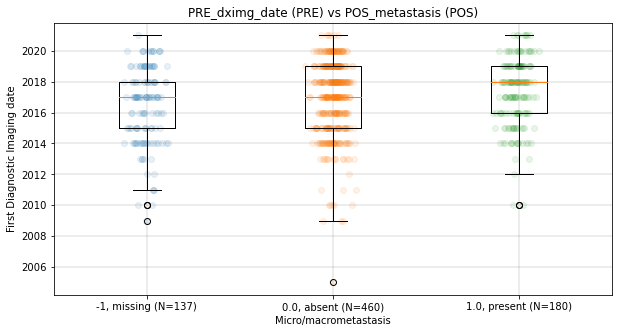

PRE_dximg_date (time, PRE) vs POS_did_the_patient_receive_pm (categorical, POS)
y_label
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_dximg_date_VS_POS_did_the_patient_receive_pm__boxplot.png


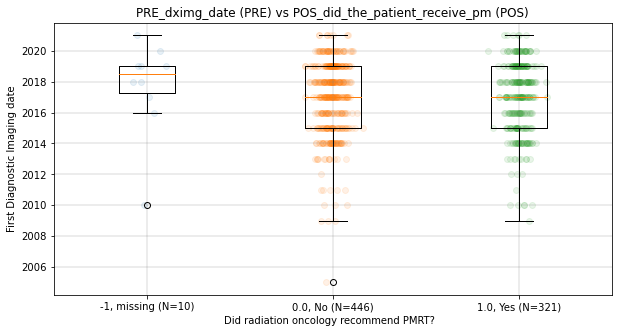

PRE_dximg_date (time, PRE) vs POS_tumor_size (real, POS)
y_label
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_dximg_date_VS_POS_tumor_size__scatter.png


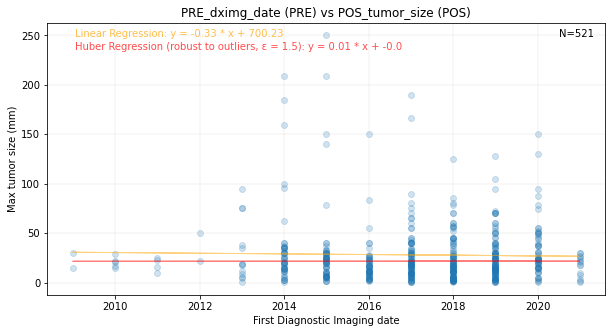

--------------------------------------------------
section1, dtype1, label1, options1, options_str1 PRE real Number of years between diagnosis imaging and surgery {} 
PRE_years_btw_dximg_surg (real, PRE) vs POS_metastasis (categorical, POS)
y_label
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_years_btw_dximg_surg_VS_POS_metastasis__boxplot.png


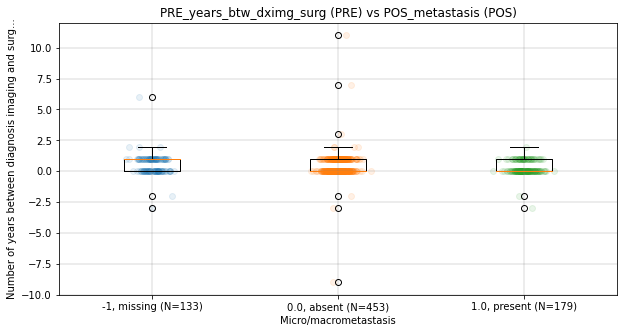

PRE_years_btw_dximg_surg (real, PRE) vs POS_did_the_patient_receive_pm (categorical, POS)
y_label
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_years_btw_dximg_surg_VS_POS_did_the_patient_receive_pm__boxplot.png


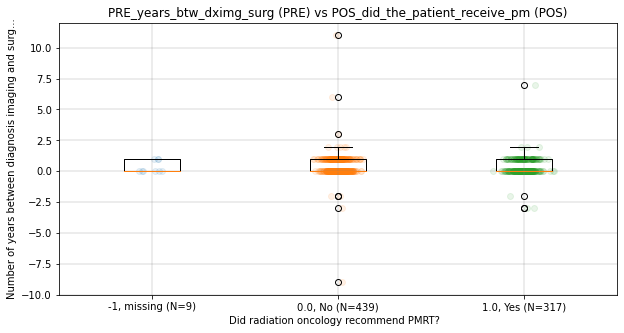

PRE_years_btw_dximg_surg (real, PRE) vs POS_tumor_size (real, POS)
y_label
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_years_btw_dximg_surg_VS_POS_tumor_size__scatter.png


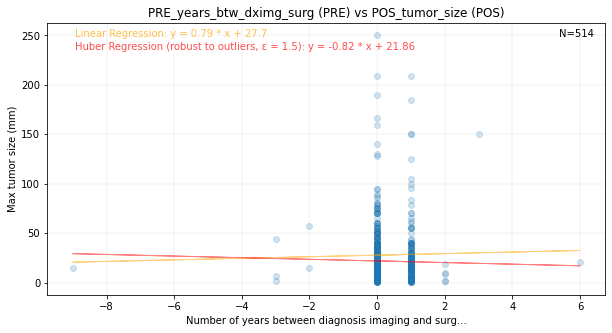

--------------------------------------------------
section1, dtype1, label1, options1, options_str1 PRE real BMI of patient, constructed from from "PRE_height_cm" and "PRE_weight_kg" {} 
PRE_bmi (real, PRE) vs POS_metastasis (categorical, POS)
y_label
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_bmi_VS_POS_metastasis__boxplot.png


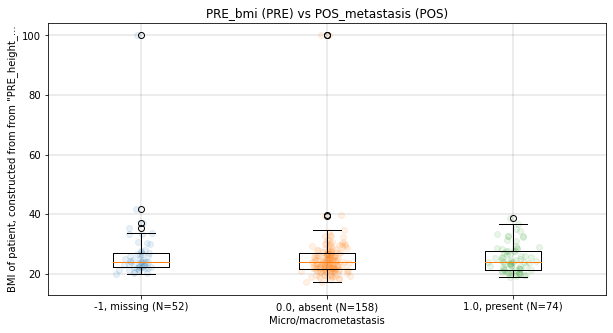

PRE_bmi (real, PRE) vs POS_did_the_patient_receive_pm (categorical, POS)
y_label
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_bmi_VS_POS_did_the_patient_receive_pm__boxplot.png


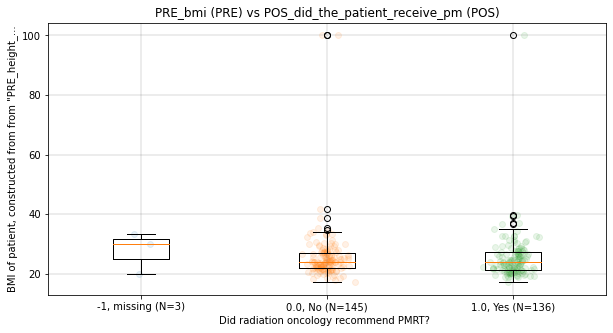

PRE_bmi (real, PRE) vs POS_tumor_size (real, POS)
y_label
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Aug2/PRE_bmi_VS_POS_tumor_size__scatter.png


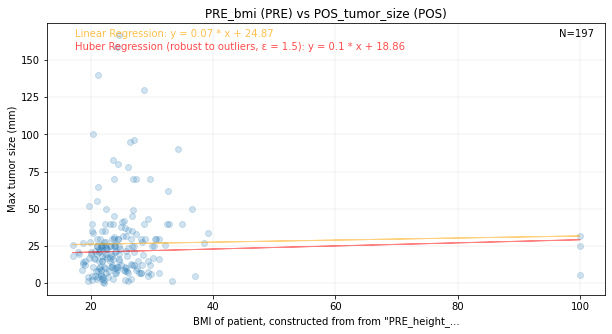

In [87]:
# Explore and visualize the relationship between the PRE composite features and the post nodal columns
# For each post nodal column, plot the distribution of the PRE composite features


def cross_tab_plots(df, cross_tab_cols_set1, cross_tab_cols_set2, show_plots, plot_missing=False):
    for col1 in cross_tab_cols_set1:
        print("-"*50)
        section1, dtype1, label1, options1, options_str1 = read_col_attributes(col1, has_missing=has_missing(df, col1))
        print("section1, dtype1, label1, options1, options_str1", section1, dtype1, label1, options1, options_str1)
        for col2 in cross_tab_cols_set2:
            section2, dtype2, label2, options2, options_str2 = read_col_attributes(col2, has_missing=has_missing(df, col2))
            print(f"{col1} ({dtype1}, {section1}) vs {col2} ({dtype2}, {section2})")
            plt.title(f"{col1} ({section1}) vs {col2} ({section2})", fontsize=12, loc="center")
            # Create cross-tab table
            if is_dtype_categorical(dtype1) and is_dtype_categorical(dtype2):
                # continue
                # If both are categorical, create a contingency table with percentages and margins
                df_cross_tab = pd.crosstab(df[col1], df[col2], margins=True)
                # Rename "All" with "Total" in the df_cross_tab columns and indices
                df_cross_tab.columns = df_cross_tab.columns.tolist()[:-1] + ["Total"]
                df_cross_tab.index = df_cross_tab.index.tolist()[:-1] + ["Total"]
                # Create percentages from cross-tab table
                values = df_cross_tab.values
                # Calculate percentages excluding the last row and last column
                percentages = values[:-1, :-1] / (values[:-1, :-1].sum()) * 100
                # Create column/row-wise margins of percentages 2D array
                row_margins = np.sum(percentages, axis=1)
                # Append 100 to row_margins
                row_margins = np.append(row_margins, 100)
                col_margins = np.sum(percentages, axis=0) 
                # Append col_margins to the end of percentages
                percentages = np.append(percentages, col_margins.reshape(1, percentages.shape[1]), axis=0)
                # Append the row_margins to the end of percentages
                percentages = np.append(percentages, row_margins.reshape(percentages.shape[0], 1), axis=1)
                annotations = np.array([f"{x}\n({round(y)}%)" for x, y in zip(values.flatten(), percentages.flatten())]).reshape(df_cross_tab.shape)
                # Rename the x-ticks and y-ticks with the options
                y_tick_labels = list([f"{k}, {v}" for k, v in options1.items()]) + ["Total"]
                x_tick_labels = list([f"{k}, {v}" for k, v in options2.items()]) + ["Total"]
                # Rotate the x-ticks and y-ticks
                # Plot the cross-tab table, which is a heatmap with no colors and black grid
                sns.heatmap(
                    df_cross_tab, annot=annotations, fmt="", cmap="Blues", annot_kws={"size": 10}, linewidths=1,
                    cbar=True, square=True, cbar_kws={"shrink": 0.5}, xticklabels=x_tick_labels, yticklabels=y_tick_labels)
                # # Add the options as x-axis labels and y-axis labels
                x_label = f"{label2}"
                y_label = f"{label1}"
                plt.xticks(rotation=0)
                plt.yticks(rotation=0)
                # Align the ticks to the center of the cell
                plot_type = "cross_tab"
            # Create box plot
            elif is_dtype_categorical(dtype1) or is_dtype_categorical(dtype2):  # One is categorical, the other is numerical
                # continue
                # If one is categorical, create a histogram with overlapping groups/categories
                cat_col, num_col = (col1, col2) if is_dtype_categorical(dtype1) else (col2, col1)
                cat_section, cat_dtype, cat_label, cat_options, cat_options_str = read_col_attributes(cat_col, has_missing=has_missing(df, cat_col))
                num_section, num_dtype, num_label, num_options, num_options_str = read_col_attributes(num_col, has_missing=has_missing(df, num_col))
                # The color of the boxplot is the category
                plt.title(f"{col1} ({section1}) vs {col2} ({section2})", fontsize=12, loc="center")
                data = {}
                for cat in cat_options.keys():
                    num_data = df[df[cat_col] == cat][num_col].values
                    num_missing_count = np.count_nonzero(num_data == -1)
                    data[cat] = [x for x in num_data if x != -1 and not np.isnan(x)]
                # print("cat_options", cat_options, data.keys())
                plt.boxplot(data.values(), labels=[f"{k}, {v} (N={len(data[k])})" for k, v in cat_options.items()])
                for i, (cat, data_vals) in enumerate(data.items()):
                    x_pos = np.random.normal(i+1, 0.05, len(data_vals))
                    plt.scatter(x_pos, data_vals, alpha=0.1)
                # Add gridlines
                plt.grid(which="major", axis="x", linestyle="-", linewidth=0.3, color="grey")
                plt.grid(which="major", axis="y", linestyle="-", linewidth=0.3, color="grey")
                x_label = f"{cat_label}"
                y_label = f"{num_label}"
                plot_type = "boxplot"
            # Create scatter plot
            else:  # Both are numerical
                # If both are numerical, create a scatter plot with the two columns
                # The x-axis is the first column, the y-axis is the second column
                data = zip(df[col1], df[col2])
                # Remove all instances of -1 and nan from the data
                data = [x for x in data if x[0] != -1 and not np.isnan(x[0]) and x[1] != -1 and not np.isnan(x[1])]
                x_data = [x[0] for x in data]
                y_data = [x[1] for x in data]
                # Plot the scatter plot
                plt.scatter(x_data, y_data, alpha=0.2)
                # Fit a linear regression line to the data and plot it
                slope, intercept = np.polyfit(x_data, y_data, 1)
                plt.plot(x_data, [slope * x + intercept for x in x_data], color="orange", linewidth=1, alpha=0.5)
                # Write the regression equation as opaque text on the top-left corner of the plot
                slope, intercept = round(slope, 2), round(intercept, 2)
                text = f"Linear Regression: y = {slope} * x + {intercept}"
                plt.text(0.05, 0.98, text, transform=plt.gca().transAxes, fontsize=10, va="top", alpha=0.7, color="orange")
                # Add another regression line that is robust to outliers using HuberRegressor
                sklearn_x_data = np.array(x_data).reshape(-1, 1)
                sklearn_y_data = np.array(y_data)
                huber_epsilon = 1.5
                model = HuberRegressor(epsilon=huber_epsilon)
                model.fit(sklearn_x_data, sklearn_y_data)
                # Plot the fitted line
                plt.plot(x_data, model.predict(sklearn_x_data), color="red", linewidth=1, alpha = 0.5)
                # Write the regression equation as opaque text on the top-left corner of the plot
                text = f"Huber Regression (robust to outliers, ε = {huber_epsilon}): y = {round(model.coef_[0], 2)} * x + {round(model.intercept_, 2)}"
                plt.text(0.05, 0.93, text, transform=plt.gca().transAxes, fontsize=10, va="top", alpha=0.7, color="red")
                # Make grid background with gridlines
                plt.grid(which="major", axis="x", linestyle="-", linewidth=0.1, color="grey")
                plt.grid(which="major", axis="y", linestyle="-", linewidth=0.1, color="grey")
                # Add a caption for number of data points to the top-right of the plot
                plt.text(0.98, 0.98, f"N={len(data)}", horizontalalignment="right", verticalalignment="top", transform=plt.gca().transAxes)
                x_label = f"{label1}"
                y_label = f"{label2}"
                plot_type = "scatter"
            # Add labels to the axes
            print("y_label", )
            x_label = x_label[:50] + "..." if len(x_label) > 50 else x_label
            y_label = y_label[:50] + "..." if len(y_label) > 50 else y_label
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            save_plot_cols(col1, col2, plot_type, plot_missing)
            if show_plots:
                plt.show()
                

cross_tab_cols_set1 = ["PRE_surg_indicat_prim___recurrent_cancer", "PRE_dximg_date", "PRE_years_btw_dximg_surg", "PRE_bmi"]
cross_tab_cols_set2 = ["POS_metastasis", "POS_did_the_patient_receive_pm", "POS_tumor_size"]
# Remove patients with BMI > 100
df["PRE_bmi"] = df["PRE_bmi"].clip(upper=100)
# Calculate PRE_years_btw_dximg_surg as difference between PRE_surgery_date and PRE_dximg_date
# If either is missing, set to np.nan
df["PRE_years_btw_dximg_surg"] = df.apply(lambda row: row["PRE_surgery_date"] - row["PRE_dximg_date"] if row["PRE_dximg_date"] != -1 and row["PRE_surgery_date"] != -1 else np.nan, axis=1)
cross_tab_plots(df, cross_tab_cols_set1, cross_tab_cols_set2, show_plots=True, plot_missing=False)

In [85]:
df["PRE_years_btw_dximg_surg"].value_counts()
# Show rows that have negative values for PRE_years_btw_dximg_surg
df[df["PRE_years_btw_dximg_surg"] < 0][["PRE_record_id", "PRE_years_btw_dximg_surg", "PRE_surgery_date", "PRE_dximg_date"]]

,PRE_record_id,PRE_years_btw_dximg_surg,PRE_surgery_date,PRE_dximg_date
74,490.0,-2.0,2016.0,2018.0
118,198.0,-1.0,2018.0,2019.0
428,617.0,-3.0,2017.0,2020.0
466,731.0,-9.0,2010.0,2019.0
480,532.0,-2.0,2018.0,2020.0
508,709.2,-2.0,2012.0,2014.0
542,631.0,-1.0,2020.0,2021.0
634,118.0,-3.0,2018.0,2021.0
675,12.0,-1.0,2018.0,2019.0
692,683.0,-3.0,2014.0,2017.0


In [69]:
cross_tab_cols_set1 = ["PRE_susp_LN_prsnt_composite", "PRE_susp_LN_max_size_composite", "PRE_tumor_max_size_composite", "PRE_height_cm", "PRE_weight_kg"]
# cross_tab_cols_set1 = ["PRE_height_cm", "PRE_weight_kg"]
cross_tab_cols_set2 = ['lymphovascular_invasion', 'metastasis', 'ln_w_micrometastasis', 'ln_w_macrometastasis', 'number_of_positive_sln', 'size_of_largest_nodal_meta', 'extranodal_extension', 'extent_of_extranodal_exten', 'mar_status',  'dis_closest_margin', 'tu_grade', 'tumor_size', 'tumor_focality', 'num_foci', 'did_the_patient_receive_pm']


In [70]:
# # calculate and print the pair-wise correlations between cross_tab_cols_set1 and cross_tab_cols_set2
# # the correlation should exclude nan and -1 values
# corr_set1_set2 = OrderedDict()
# for col1 in cross_tab_cols_set1:
#     for col2 in cross_tab_cols_set2:
#         print("-" * 20 + f"Processing {col1} and {col2}" + "-" * 20)
#         section1, dtype1, label1, options1, options_str1 = read_col_attributes(col1)
#         section2, dtype2, label2, options2, options_str2 = read_col_attributes(col2)
#         # Remove rows where either col1 or col2 is -1 or nan
#         data = zip(df[col1], df[col2])
#         data = [x for x in data if x[0] != -1 and not np.isnan(x[0]) and x[1] != -1 and not np.isnan(x[1])]
#         x_data = [x[0] for x in data]
#         y_data = [x[1] for x in data]
#         # Apply map to the data, depending on the options
#         for val1, desc1 in options1.items():
#             if val1 == 2 and desc1.lower() == "indeterminate":
                
                
#             elif val1 == 3 and desc1.lower() == "unknown":
#                 # Replace all occurences of 3 with 0.5 in the data
#                 x_data = [x if x != 3 else 0.5 for x in x_data]
#                 print(f"Replaced all 3 values with 0.5 in {col1} because it is unknown")
#             elif val1 == 2 and desc1.lower() == "absent":
#                 # Replace all occurences of 2 with 0 in the data
#                 x_data = [x if x != 2 else 0 for x in x_data]
#                 print(f"Replaced all 2 values with 0 in {col1} because it is absent")

#         # Calculate the correlation between the two columns
#         corr = np.corrcoef(x_data, y_data)[0, 1]
#         corr_set1_set2[(col1, col2)] = (corr, len(data))
        


# # Print the correlations
# # First sort the correlation by absolute value
# corr_set1_set2 = OrderedDict(sorted(corr_set1_set2.items(), key=lambda x: abs(x[1][0]), reverse=True))
# for (col1, col2), (corr, len_data) in corr_set1_set2.items():
#     section1, dtype1, label1, options1, options_str1 = read_col_attributes(col1)
#     section2, dtype2, label2, options2, options_str2 = read_col_attributes(col2)
#     print("-"*50)
#     print(f"options for {col1}: {options_str1}")
#     print(f"options for {col2}: {options_str2}")
#     print(f"Correlation between: {label1} ({section1}) & {label2} ({section2}) = {round(corr, 2)}   (N={len_data})")
    